## Capstone 1 Project: Statistical Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st

### Dataset source
https://raw.githubusercontent.com/nwugocc/Capstone-Project-1/master/data/data1.txt

In [2]:
df1 = pd.read_csv('data/data1.txt', index_col='yrmo', parse_dates=True).sort_index()
df1.index.name = 'Date'
df1.shape

(42074, 7)

In [3]:
df1.columns = [i.lower() for i in df1.columns]
df1.head()

,physicianid,adderallpatients,adderallpayments,antibiopatients,antibiopayments,opioidpatients,opioidpayments
Date,,,,,,,
2015-01-01,6vFQfkVIyHglLHjv,NaN,NaN,4.0,2439.0,2.0,2.0
2015-01-01,KtIQV9FihhozcS4O,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01,nh9P8B7ik2qYlruB,6.0,791.0,9.0,5760.0,3.0,174.0
2015-01-01,1fZbRx3Qm2h2rmPP,NaN,NaN,1.0,97.0,NaN,NaN
2015-01-01,UY8bW4koFtgJI8J7,10.0,16299.0,NaN,NaN,NaN,NaN


#### Counts for non-null values within medication groups matched except for antobiopayments & antibiopatients 

In [4]:
df1.info()  

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42074 entries, 2015-01-01 to 2017-10-01
Data columns (total 7 columns):
physicianid         42074 non-null object
adderallpatients    23889 non-null float64
adderallpayments    23889 non-null float64
antibiopatients     39829 non-null float64
antibiopayments     39826 non-null float64
opioidpatients      12588 non-null float64
opioidpayments      12588 non-null float64
dtypes: float64(6), object(1)
memory usage: 2.6+ MB


In [5]:
# Imputing the missing antibiopayments values

df1.loc[(df1['antibiopayments'].isnull()) & (df1['antibiopatients'].notnull()), 'antibiopayments'] = 0
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42074 entries, 2015-01-01 to 2017-10-01
Data columns (total 7 columns):
physicianid         42074 non-null object
adderallpatients    23889 non-null float64
adderallpayments    23889 non-null float64
antibiopatients     39829 non-null float64
antibiopayments     39829 non-null float64
opioidpatients      12588 non-null float64
opioidpayments      12588 non-null float64
dtypes: float64(6), object(1)
memory usage: 3.8+ MB


### Exploratory data analysis with visualizations

In [6]:
# Descriptive statistics analysis of the dataset
df1.describe() 

,adderallpatients,adderallpayments,antibiopatients,antibiopayments,opioidpatients,opioidpayments
count,23889.000000,2.388900e+04,39829.000000,3.982900e+04,12588.000000,1.258800e+04
mean,4.921972,1.828657e+03,6.378217,2.166645e+04,3.095249,2.980236e+03
std,9.248193,2.293074e+04,12.741038,8.379241e+04,6.943019,6.421729e+04
min,1.000000,-1.177100e+04,1.000000,-9.400000e+03,0.000000,-1.000000e+01
25%,1.000000,4.600000e+01,2.000000,3.020000e+02,1.000000,1.500000e+01
50%,3.000000,2.450000e+02,3.000000,2.906000e+03,2.000000,1.220000e+02
75%,5.000000,8.580000e+02,6.000000,1.430000e+04,3.000000,4.410000e+02
max,341.000000,1.732264e+06,285.000000,2.423404e+06,318.000000,2.823021e+06


Descriptive statistics analysis of the dataset show that on average:
* physicians saw about 4.9 adderall patients and charged about 1828 per month
* physicians saw about 6.4 antibiotic patients and charged about 21666 per month
* physicians saw about 3.1 opioid patients and charged about 2980 per month

Hence, it appears physicians received higher payments per patient for prescribing antibiotics compared to adderall or opioid. Likewise, it appears physicians received higher payments per patient for prescribing opioids compared to adderall. This could be due to the fact that antibiotic and opioid prescribing physicians might prefer to prescribe more expensive branded products or might be overprescribing drugs to repeat patients.

Differences in payments per patient will be further investigated later. First is to investigate the _zero_ value minimum observed in opioidpatients.

### Investigating the _zero_ 'opioidpatients' entry as a potential error 

In [7]:
#df1[df1['opioidpatients']==0].loc[:,['physicianid', 'opioidpatients','opioidpayments']]
df1[df1['physicianid'] == 'wwyJwO6CL1dqIooh'].head(3)

,physicianid,adderallpatients,adderallpayments,antibiopatients,antibiopayments,opioidpatients,opioidpayments
Date,,,,,,,
2015-01-01,wwyJwO6CL1dqIooh,NaN,NaN,NaN,NaN,13.0,15443.0
2015-02-01,wwyJwO6CL1dqIooh,NaN,NaN,NaN,NaN,0.0,63451.0
2015-03-01,wwyJwO6CL1dqIooh,NaN,NaN,NaN,NaN,35.0,16468.0


The _zero_ value entry is associated with physicianid 'wwyJwO6CL1dqIooh' on the month of 2015-02. Since this was the only instance with a _zero_ patient entry for any physician in the entire dataset, and also because there was a signicant payment amount associated with this entry, it is assumed that the _zero_ entry must be an error. 

### Using linear regression to impute (interpolate) the _zero_ 'opioidpatients' entry

Pearson correlation coefficent = 0.8517051540283693


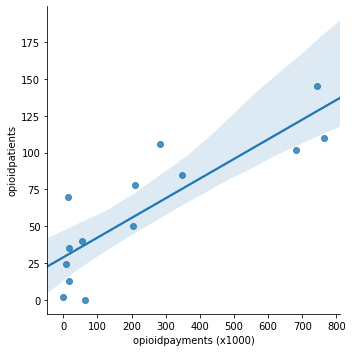

In [8]:
# Calculating r of physicianid ''wwyJwO6CL1dqIooh' patient volumes and payments
physid_wwy = df1[df1['physicianid'] == 'wwyJwO6CL1dqIooh'][['opioidpatients','opioidpayments']]
wwy_r = np.corrcoef(physid_wwy.opioidpayments, physid_wwy.opioidpatients)
print('Pearson correlation coefficent =',wwy_r[0,1])

# Regression plot of patient volumes and payments for physicianid 'wwyJwO6CL1dqIooh' 
physid_wwy = df1[df1['physicianid'] == 'wwyJwO6CL1dqIooh'][['opioidpatients','opioidpayments']]
phys_ww = physid_wwy.copy()
phys_ww['opioidpayments'] = phys_ww['opioidpayments'] / 1000
sns.lmplot(x='opioidpayments', y='opioidpatients', data=phys_ww)
plt.xlabel('opioidpayments (x1000)');

In [9]:
# Extracting the slope and intercept parameters
slope, intercept = np.polyfit(physid_wwy['opioidpayments'],physid_wwy['opioidpatients'], 1)
val = slope * 63451 + intercept
val

37.373342633106645

In [10]:
# Imputing the zero 'opioidpatients' value using linear regression
slope, intercept = np.polyfit(physid_wwy['opioidpayments'],physid_wwy['opioidpatients'], 1)
df1.loc[(df1.physicianid == 'wwyJwO6CL1dqIooh') & (df1.opioidpatients == 0), 'opioidpatients'] = val

In [11]:
# Confirming that the zero 'opioidpatients' value is replaced with the val = 37.3733...
df1[df1['physicianid'] == 'wwyJwO6CL1dqIooh'].head()

,physicianid,adderallpatients,adderallpayments,antibiopatients,antibiopayments,opioidpatients,opioidpayments
Date,,,,,,,
2015-01-01,wwyJwO6CL1dqIooh,NaN,NaN,NaN,NaN,13.000000,15443.0
2015-02-01,wwyJwO6CL1dqIooh,NaN,NaN,NaN,NaN,37.373343,63451.0
2015-03-01,wwyJwO6CL1dqIooh,NaN,NaN,NaN,NaN,35.000000,16468.0
2015-04-01,wwyJwO6CL1dqIooh,NaN,NaN,NaN,NaN,106.000000,283647.0
2015-05-01,wwyJwO6CL1dqIooh,NaN,NaN,NaN,NaN,78.000000,208911.0


### Visualizing probability distributions of log transformed and simulated values

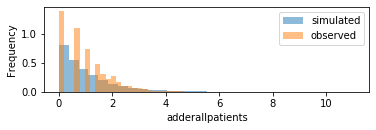

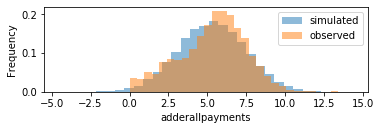

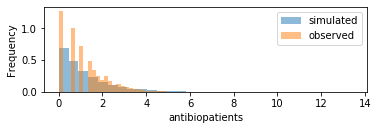

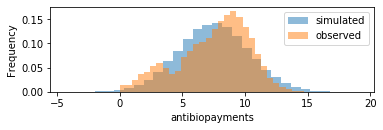

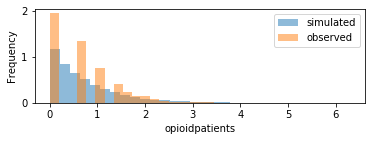

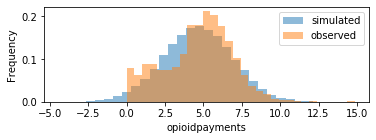

In [12]:
np.random.seed(3)

f = 0
for col in df1.columns[1:]:
    clean_col = [i for i in df1[col].dropna() if i > 0]
    if 'patients' in col:  
        scale, size = st.expon.fit(np.log(clean_col))
        simulated = st.expon(scale, size).rvs(len(clean_col))
        
    else:
        mean, std = st.norm.fit(np.log(clean_col))
        simulated = st.norm(mean, std).rvs(len(clean_col))
    
    f += 1
    plt.figure(figsize=(10,5))
    plt.subplot(3,2,f)
    plt.hist(simulated, bins=30, alpha=0.5, label='simulated', density=True)
    plt.hist(np.log(clean_col), bins=30, alpha=0.5, label='observed', density=True)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend() 
    plt.tight_layout()

# plt.subplot(3,2,1)
# plt.legend();

Probability distributions show that log transformed patient volumes appear to be exponetially distributed while log transformed payments appear to be normally ditributed. 

### Using box plots and empirical cummulative density functions (ECDFs) to assess descriptive statistics results

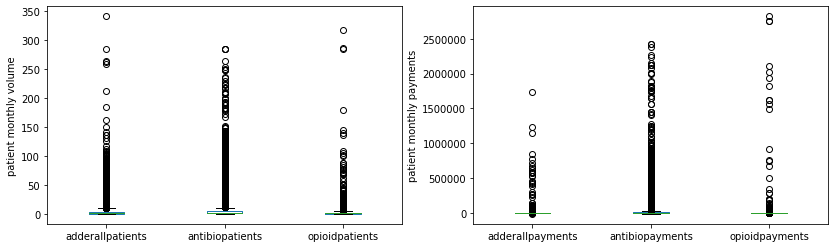

In [13]:
# Box plots of patient monthly volumes and payments per physician 
fig, axes = plt.subplots(1, 2, figsize=(14,4), squeeze=False)
df1.loc[:,['adderallpatients','antibiopatients','opioidpatients']].plot(kind='box', ax=axes[0, 0])
df1.loc[:,['adderallpayments','antibiopayments','opioidpayments']].plot(kind='box', ax=axes[0, 1])
axes[0,0].set_ylabel('patient monthly volume')
axes[0,1].set_ylabel('patient monthly payments') ;

Box plots confirm the presence of outliers. This means that some physicians see far more patients and/or receive far more payments per month compared to other physicians. It is suspected that some of the physicians in the group of outliers might be the ones involved in overprescribing drugs recklessly or for profit.

In [14]:
# Generating functions for plotting ecdfs
def ecdf(data):
    '''Generate x and y values for empirical cummulative density function plots'''
    x = np.sort(data)
    y = np.arange(1, len(data)+1) / len(data)
    return x, y

In [15]:
# Generating a and y variables for ecdfs
adderall_patients_x, adderall_patients_y = ecdf(df1.adderallpatients.dropna())
antibio_patients_x, antibio_patients_y = ecdf(df1.antibiopatients.dropna())
opioid_patients_x, opioid_patients_y = ecdf(df1.opioidpatients.dropna())
adderall_payments_x, adderall_payments_y = ecdf(df1.adderallpayments.dropna())
antibio_payments_x, antibio_payments_y = ecdf(df1.antibiopayments.dropna())
opioid_payments_x, opioid_payments_y = ecdf(df1.opioidpayments.dropna())

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log
  if sys.path[0] == '':
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


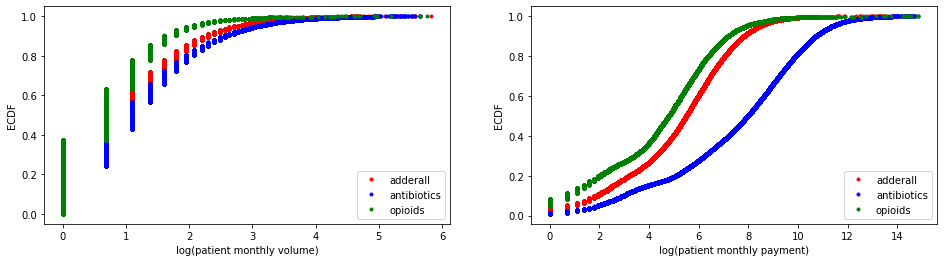

In [16]:
# Plotting ecdfs
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(np.log(adderall_patients_x), adderall_patients_y, marker='.', linestyle='none', color='r')
plt.plot(np.log(antibio_patients_x), antibio_patients_y, marker='.', linestyle='none', color='b')
plt.plot(np.log(opioid_patients_x), opioid_patients_y, marker='.', linestyle='none', color='g')
plt.xlabel('log(patient monthly volume)') ; plt.ylabel('ECDF')
plt.legend(('adderall','antibiotics','opioids'), loc='lower right')

plt.subplot(1,2,2) 
plt.plot(np.log(adderall_payments_x), adderall_payments_y, marker='.', linestyle='none', color='r')
plt.plot(np.log(antibio_payments_x), antibio_payments_y, marker='.', linestyle='none', color='b')
plt.plot(np.log(opioid_payments_x), opioid_payments_y, marker='.', linestyle='none', color='g')
plt.xlabel('log(patient monthly payment)') ; plt.ylabel('ECDF')
plt.legend(('adderall','antibiotics','opioids'), loc='lower right');

The ecdf plots confirmed information from descriptive statistics, which showed that antibitoics prescribing physicians had the highest monthly average volumes and highest monthly payments compared to adderall or opioid prescribing physicians. Additionally, ecdf plots showed that adderall prescribing physicians had higher monthly patient volumes compared to opioid prescribing physicians. 

Interestingly, while descriptive statistics analysis showed a higher monthly average payment for opioids compared to adderall, ecdf plots suggest that at least 85% of physicians received higher monthly payments for adderall than opioids. This suggests that the source of the higher monthly payments for opioids compared to adderall is restricted to payments associated with less than 15% of opioid prescribing physicians. Before investigating this further, it is important to first comfirm that the mean differences in opioid and adderall patient volumes and payments are statistically signifcant. 

### Using bootstrapping to compare average monthly patient volumes and payments for adderall and opioid
The null hypothesis is that there's no difference in the mean monthly patient volumes and payments for adderall and opioids 

In [17]:
np.random.seed(47)

# Computing the differences in means
adderallpatients = df1.adderallpatients.dropna() 
opioidpatients = df1.opioidpatients.dropna() 
adderallpayments = df1.adderallpayments.dropna()
opioidpayments = df1.opioidpayments.dropna()

patients_diff = np.mean(adderallpatients) - np.mean(opioidpatients)
payments_diff = np.mean(opioidpayments) - np.mean(adderallpayments)

# Concatenating samples
conc_patients_mean = np.mean(np.concatenate((adderallpatients, opioidpatients)))
conc_payments_mean = np.mean(np.concatenate((adderallpayments, opioidpayments)))

# Shifting the means of both samples to match the concatenated mean
add_patients_shifted = adderallpatients + conc_patients_mean - np.mean(adderallpatients)
opi_patients_shifted = opioidpatients + conc_patients_mean - np.mean(opioidpatients)
add_payments_shifted = adderallpayments + conc_payments_mean - np.mean(adderallpayments)
opi_payments_shifted = opioidpayments + conc_payments_mean - np.mean(opioidpayments)

# Initializing replicates 
bs_patients_replicates = np.empty(10000)
bs_payments_replicates = np.empty(10000)

# Generating bs_patients replicates
for i in range(10000):
    add_rep = np.random.choice(add_patients_shifted, size=len(add_patients_shifted))
    opi_rep = np.random.choice(opi_patients_shifted, size=len(opi_patients_shifted))
    bs_patients_replicates[i] = np.mean(add_rep) - np.mean(opi_rep)

# Generating bs_payments replicates
for i in range(10000):
    add_rep = np.random.choice(add_payments_shifted, size=len(add_payments_shifted))
    opi_rep = np.random.choice(opi_payments_shifted, size=len(opi_payments_shifted))
    bs_payments_replicates[i] = np.mean(opi_rep) - np.mean(add_rep)

In [18]:
# Computing confidence intervals
conf_int_lower1 = np.percentile(bs_patients_replicates, 2.5)
conf_int_upper1 = np.percentile(bs_patients_replicates, 97.5)
conf_int_lower2 = np.percentile(bs_payments_replicates, 2.5)
conf_int_upper2 = np.percentile(bs_payments_replicates, 97.5)

p-value of difference in mean monthly patient volumes = 0          p-value of difference in mean monthly payments = 0.0327


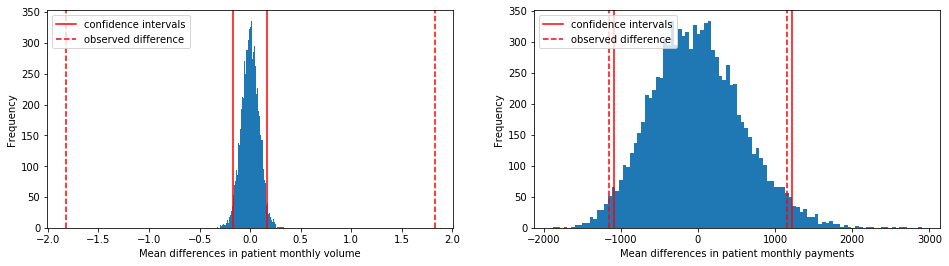

In [19]:
# Plotting histograms of mean difference replicates
fig, ax = plt.subplots(1, 2, figsize=(16,4), squeeze=False)
ax[0,0].hist(bs_patients_replicates, bins=100)
ax[0,0].axvline(conf_int_lower1, color='red', label='confidence intervals')
ax[0,0].axvline(conf_int_upper1, color='red')
ax[0,0].axvline(patients_diff, color='red', ls='--', label='observed difference')
ax[0,0].axvline(-patients_diff, color='red', ls='--')
ax[0,0].set_xlabel('Mean differences in patient monthly volume')
ax[0,0].legend(loc='upper left')
ax[0,0].set_ylabel('Frequency')

ax[0,1].hist(bs_payments_replicates, bins=100)
ax[0,1].axvline(conf_int_lower2, color='red', label='confidence intervals')
ax[0,1].axvline(conf_int_upper2, color='red')
ax[0,1].axvline(payments_diff, color='red', ls='--', label='observed difference')
ax[0,1].axvline(-payments_diff, color='red', ls='--')
ax[0,1].set_xlabel('Mean differences in patient monthly payments')
ax[0,1].legend(loc='upper left')
ax[0,1].set_ylabel('Frequency')

# Computing p-values
p1 = np.sum(bs_patients_replicates >= patients_diff) / len(bs_patients_replicates)
p2 = np.sum(bs_payments_replicates >= payments_diff) / len(bs_payments_replicates)
print("p-value of difference in mean monthly patient volumes = %g   \
       p-value of difference in mean monthly payments = %g" % (p1, p2)) ;

The bootstrapped hypothesis test suggest that on average physicians receive signifcantly more adderall patients per month compared to opioid patients. However, the average monthly payments collected for opioid patients is signifcantly higher (at the 5% signifcance level) compared to payments from adderall patients. This suggests that opioid patients have a higher revenue margin compared to adderall patients.

### Investigating payment received per patient per drug type
Since the data suggests a higher revenue margin per opioid prescription compared to adderall, the average payments received per patient per drug type per physician was investigated. 

In [20]:
# Creating three new columns to capture the average payments received per patient per physician per drug type
df1['adderall_pay_rate'] = df1['adderallpayments'] / df1['adderallpatients']
df1['antibio_pay_rate'] = df1['antibiopayments'] / df1['antibiopatients']
df1['opioid_pay_rate'] = df1['opioidpayments'] / df1['opioidpatients']

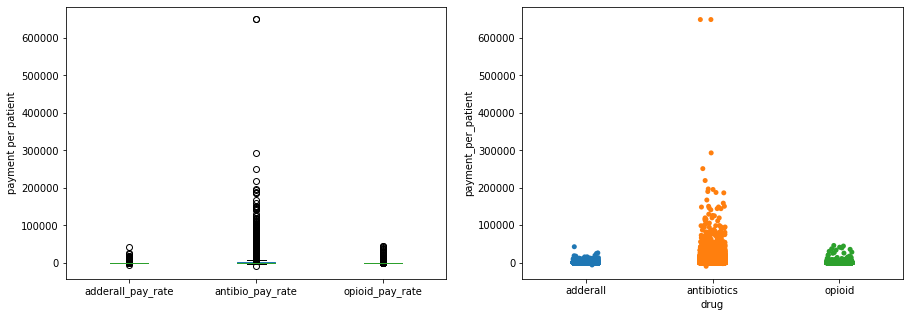

In [21]:
# Box and strip plots to visualize the payments received per patient per physician per drug type

fig, axes = plt.subplots(1, 2, figsize=(15,5), squeeze=False)

df1_melt = df1.loc[:,['adderall_pay_rate','antibio_pay_rate','opioid_pay_rate']]
df1_melt.columns = ['adderall','antibiotics','opioid']
df1_melt = df1_melt.melt(var_name = 'drug', value_name ='payment_per_patient')
sns.stripplot(x='drug', y='payment_per_patient', data = df1_melt, size=5, jitter=True,ax=axes[0, 1])
df1.loc[:,['adderall_pay_rate','antibio_pay_rate','opioid_pay_rate']].plot(kind='box', ax=axes[0, 0])
axes[0,0].set_ylabel('payment per patient') ;

In [22]:
# Descriptive stats of payments received per patient per physician per drug type
df1.loc[:,['adderall_pay_rate','antibio_pay_rate','opioid_pay_rate']].describe()

,adderall_pay_rate,antibio_pay_rate,opioid_pay_rate
count,23889.000000,39829.000000,12588.000000
mean,259.683273,3017.228591,250.260730
std,834.308953,8636.190454,1291.643871
min,-5885.500000,-9400.000000,-8.000000
25%,21.714286,130.666667,9.000000
50%,85.095238,886.500000,62.500000
75%,227.300000,3108.250000,197.000000
max,42753.000000,649413.000000,46170.350000


The box and jitterred strip plots show the presence of outliers, especially for antibitotics prescriptions which had a mean of 3017 payment per patient but two situations (possibly repeat patients) with physicians receiving over 640000 in payments per patient.

In [23]:
adderall_cv = st.variation(df1.adderall_pay_rate.dropna())
antibio_cv = st.variation(df1.antibio_pay_rate.dropna())
opioid_cv = st.variation(df1.opioid_pay_rate.dropna())
print('Coefficient of variation in payment per patient for adderall = %03f' % adderall_cv)
print('Coefficient of variation in payment per patient for antibitotics = %03f' % antibio_cv)
print('Coefficient of variation in payment per patient for opioids = %03f' % opioid_cv)

Coefficient of variation in payment per patient for adderall = 3.212727
Coefficient of variation in payment per patient for antibitotics = 2.862256
Coefficient of variation in payment per patient for opioids = 5.160988


Given the presence of outliers, especially in payment per patient rates for antibitoics, it was not surprising that the coefficient of variations in payment per patient were high irrespective of drug type. However, opioid prescribing physicians had a coefficent of variation in payment per patient that was over 1.5x and 1.8x that of adderall and antibitoic prescribing physicians, respectively. Thus, opioid prescribing physicians had the widest variation on the payments received per opioid patient. 

In [24]:
# Generating a and y variables for ecdfs of payments per patient
adderall_payrate_x, adderall_payrate_y = ecdf(df1.adderall_pay_rate.dropna())
antibio_payrate_x, antibio_payrate_y = ecdf(df1.antibio_pay_rate.dropna())
opioid_payrate_x, opioid_payrate_y = ecdf(df1.opioid_pay_rate.dropna())

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


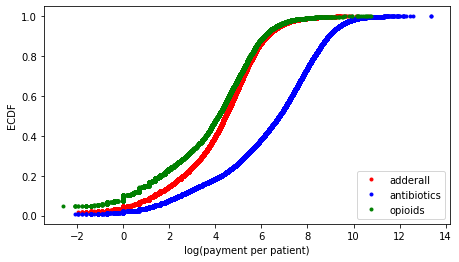

In [25]:
# Plotting ecdfs
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(np.log(adderall_payrate_x), adderall_payrate_y, marker='.', linestyle='none', color='r')
plt.plot(np.log(antibio_payrate_x), antibio_payrate_y, marker='.', linestyle='none', color='b')
plt.plot(np.log(opioid_payrate_x), opioid_payrate_y, marker='.', linestyle='none', color='g')
plt.xlabel('log(payment per patient)') ; plt.ylabel('ECDF') 
plt.legend(('adderall','antibiotics','opioids'), loc='lower right');

Box plots, descriptive statistics and ecdfs show that physicians received significantly more revenue per patient by prescribing antibiotics. However, the mean pay rate from opioid patients was only slightly higher than that for adderall patients. Bootstrapping will be used to further determine the signifcance of the difference in payment per patient between adderall and opioid patients.

### Using bootstrapping to compare average payment per patient for adderall and opioid
The null hypothesis is that there's no difference in the mean avaerage payment per patient for adderall and opioids 

In [26]:
np.random.seed(47)

# Computing the differences in mean payment per patient
adderall_payrate = df1.adderall_pay_rate.dropna()
opioid_payrate = df1.opioid_pay_rate.dropna() 

payrate_diff = np.mean(opioid_payrate) - np.mean(adderall_payrate)

# Concatenating samples
conc_payrate_mean = np.mean(np.concatenate((adderall_payrate, opioid_payrate)))

# Shifting the means of both samples to match the concatenated mean
add_payrate_shifted = adderall_payrate + conc_payrate_mean - np.mean(adderall_payrate)
opi_payrate_shifted = opioid_payrate + conc_payrate_mean - np.mean(opioid_payrate)

# Initializing replicates 
bs_payrate_replicates = np.empty(10000)

# Generating bs_payrate replicates
for i in range(10000):
    add_rep = np.random.choice(add_payrate_shifted, size=len(add_payrate_shifted))
    opi_rep = np.random.choice(opi_payrate_shifted, size=len(opi_payrate_shifted))
    bs_payrate_replicates[i] = np.mean(opi_rep) - np.mean(add_rep)

In [27]:
# Computing confidence intervals
conf_int_lower = np.percentile(bs_payrate_replicates, 2.5)
conf_int_upper = np.percentile(bs_payrate_replicates, 97.5)

p-value of difference in mean payment per patient = 0.7671


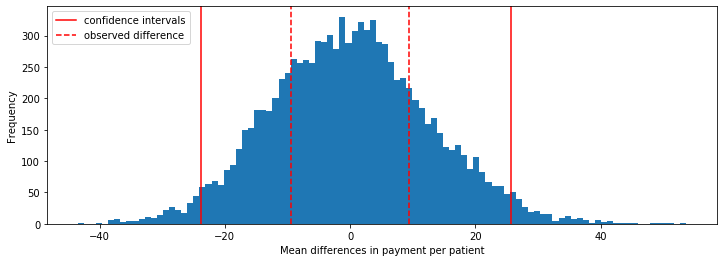

In [28]:
# Plotting histograms of mean difference replicates
plt.figure(figsize=(12,4))
plt.hist(bs_payrate_replicates, bins=100)
plt.axvline(conf_int_lower, color='red', label='confidence intervals')
plt.axvline(conf_int_upper, color='red')
plt.axvline(payrate_diff, color='red', ls='--', label='observed difference')
plt.axvline(-payrate_diff, color='red', ls='--')
plt.xlabel('Mean differences in payment per patient')
plt.legend(loc='upper left')
plt.ylabel('Frequency');

# Computing p-value
p = np.mean(bs_payrate_replicates >= payrate_diff)
#p_ = np.sum(bs_payrate_replicates >= payrate_diff) / len(bs_payrate_replicates)

print('p-value of difference in mean payment per patient =',p)

The bootstrapped hypothesis test suggests that there is no signifcant difference (at the 5% signifcance level) between the payments received per patient for adderall and opioids.

Hence, the initial conclusion is that despite seeing signifcantly fewer opioid patients compared to adderall, the signifcantly higher monthly payments from opioid compared to adderall prescriptions is likely due to prescriptions to repeat patients. 

### Analyzing correlations between patient volumes and payments for the different drug types

In [29]:
# Aggregating dataset by date to simplify the dataset prior to correlation matrix analyses
df1.groupby('Date').sum().tail() 

,adderallpatients,adderallpayments,antibiopatients,antibiopayments,opioidpatients,opioidpayments,adderall_pay_rate,antibio_pay_rate,opioid_pay_rate
Date,,,,,,,,,
2017-06-01,2124.0,517995.0,4613.0,16622137.0,575.0,105434.0,103926.451973,2.153530e+06,42002.476722
2017-07-01,1656.0,468758.0,4231.0,15072131.0,480.0,92645.0,96522.743415,1.744820e+06,35908.349595
2017-08-01,1581.0,445137.0,3295.0,10346447.0,530.0,285853.0,83010.978119,1.482375e+06,37376.628221
2017-09-01,1257.0,350291.0,2604.0,8705042.0,317.0,52527.0,49063.363804,9.391781e+05,16235.564938
2017-10-01,6.0,1681.0,10.0,690.0,0.0,0.0,280.166667,6.900000e+01,0.000000


Entries for the month of 2017-10 are incomplete. Hence, thsi month will be excluded from time series analyses

In [30]:
# Creating a new dataset that excludes the month of 2017-10
df1_d = df1.loc[:'2017-09',:].groupby('Date').sum()

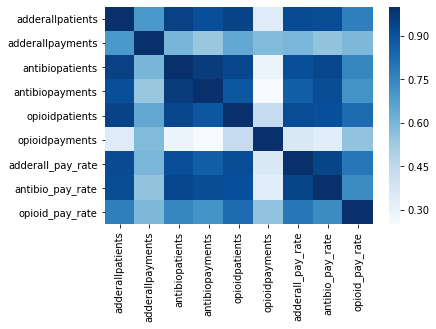

In [49]:
# heat map visualization of correlation matrix
df1_corr = df1_d.corr()
sns.heatmap(df1_corr, cmap='Blues') ;

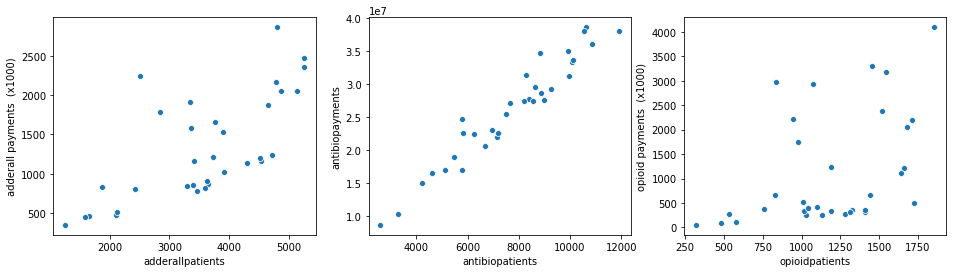

In [32]:
# Visualization of scatterplots between patient volumes and payments per drug 
adderall_ = df1_d.loc[:,['adderallpatients','adderallpayments']]
adderall_['adderallpayments'] = adderall_['adderallpayments'] / 1000
antibio_ = df1_d.loc[:,['antibiopatients','antibiopayments']]
opioid_ = df1_d.loc[:,['opioidpatients','opioidpayments']]
opioid_['opioidpayments'] = opioid_['opioidpayments'] / 1000
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
sns.scatterplot(x='adderallpatients', y='adderallpayments', data=adderall_)
plt.ylabel('adderall payments  (x1000)')
plt.subplot(1,3,2)
sns.scatterplot(x='antibiopatients', y='antibiopayments', data=antibio_)
plt.subplot(1,3,3)
sns.scatterplot(x='opioidpatients', y='opioidpayments', data=opioid_)
plt.ylabel('opioid payments  (x1000)');

Correlation matrix shows strong relationships between antibiotic patient volumes and antibiotic payment amounts suggesting a predictable increase in payments as patient volumes increase for antibiotic prescribing physicians. This was not the case with adderall and opioid prescribing physicians, which showed very weak correlations between patient volumes and payments. This suggests that something other than patient volume was driving the payment rates for adderall and opioid prescribing physicians.

### Identifing physicians that are potentially overprescribing medications
This will involve first identifying physicians above the 80th percentile for average monthly payments received and then from that list determine those who had 3 or more avtive months and whose payments do not correlate with patient volume.

In [33]:
# Grouping the dataset by physicianid to show a total of 3010 unique physicians in the dataset
df1_p = df1.groupby('physicianid').mean()
df1_p.shape

(3010, 9)

In [34]:
# Creating subset datasets from df1_p according to drug type
adderall = df1_p.loc[:,['adderallpatients', 'adderallpayments','adderall_pay_rate']].dropna()
antibio = df1_p.loc[:,['antibiopatients', 'antibiopayments','antibio_pay_rate']].dropna()
opioid = df1_p.loc[:,['opioidpatients', 'opioidpayments','opioid_pay_rate']].dropna()

In [35]:
# Sorting the datasets based on monthly payments
adderall.sort_values('adderallpayments', inplace=True)
antibio.sort_values('antibiopayments', inplace=True)
opioid.sort_values('opioidpayments', inplace=True)

In [36]:
# Creating a function that identifies physicians with unsual prescription patterns: suspect_phys_finder

def suspect_phys_finder(datasets, percentile=50, pearson_r=0.5):
    
    '''Selects physicians with mean monthly payments above selected percentile, with 3 or more active months 
        and with pearson's correlation coefficent between payments and patient volumes less than selected r'''
    
    drugs = ['adderall', 'antibio', 'opioid']
    xs_add, xs_antibio, xs_opi = [],[],[]
    
    # Select dataset from a list: datasets
    for data in datasets:
        
        # Select drug type from a list: drugs
        for drug in drugs:
            
            # Select drug type based on match to column name
            if drug in data.columns[1]:
                
                # Calculate value of selected percentile for mean monthly payments: drug_perc 
                drug_perc = np.percentile(data[data.columns[2]], percentile)
                
                # Identifying physicians with mean monthly payments larger than percentile value: drug_over_perc 
                drug_over_perc = data[data[data.columns[2]] > drug_perc]
                
                # loop through the list of physicians in drug_over_perc
                for phys in drug_over_perc.index:
                    
                    # Slice out the prescription history of selected physician in new df: phys_df
                    phys_df = df1.loc[(df1['physicianid'] == phys),:].dropna()
                    
                    # Checking that the physician has at least 3 active months
                    if len(phys_df) >= 3:
                        
                        # Compute pearson's correlation coefficent of monthly payments and patient volume
                        x = phys_df.loc[:,data.columns[0]]
                        y = phys_df.loc[:,data.columns[1]]
                        r_corr = np.corrcoef(x, y)
                        
                        # Select physician id if coefficient is less than chosen r
                        if r_corr[0,1] is not None and r_corr[0,1] < pearson_r:
                            if drug == 'adderall': 
                                xs_add.append(phys)
                            elif drug == 'antibio':
                                xs_antibio.append(phys)
                            else:
                                xs_opi.append(phys)
         
    # Store selected physician ids in dictionary: xs_phys
    xs_phys = {'adderall':xs_add, 'antibio':xs_antibio, 'opioid':xs_opi}
       
    return xs_phys    

In [37]:
# Using the function to identify physicians with unusual prescription patterns
datasets = [adderall, antibio, opioid]
xs_phys = suspect_phys_finder(datasets, percentile=80, pearson_r=0.7)

C:\Anaconda\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Anaconda\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [38]:
xs_phys_all = set(xs_phys['adderall']).intersection(set(xs_phys['antibio']), set(xs_phys['opioid']))
xs_phys_add_anti = set(xs_phys['adderall']).intersection(set(xs_phys['antibio']))
xs_phys_add_opi = set(xs_phys['adderall']).intersection(set(xs_phys['opioid']))
xs_phys_anti_opi = set(xs_phys['antibio']).intersection(set(xs_phys['opioid']))
all_ = df1_p.loc[df1_p.adderallpatients.notnull() & df1_p.antibiopatients.notnull() & df1_p.opioidpatients.notnull()]
add_opi = df1_p.loc[df1_p.adderallpatients.notnull() & df1_p.opioidpatients.notnull()]
add_anti = df1_p.loc[df1_p.adderallpatients.notnull() & df1_p.antibiopatients.notnull()]
anti_opi = df1_p.loc[df1_p.antibiopatients.notnull() & df1_p.opioidpatients.notnull()]
print('Physicians likely overprescribing adderall = %d out of %d' % (len(xs_phys['adderall']), len(adderall)))
print('Physicians likely overprescribing antibiotics = %d out of %d' % (len(xs_phys['antibio']), len(antibio)))
print('Physicians likely overprescribing opioids = %d out of %d' % (len(xs_phys['opioid']), len(opioid)))
print('Physicians likely overprescribing all drugs = %d out of %d' % (len(xs_phys_all), len(all_)))
print('Physicians likely overprescribing both adderall and antibiotics = %d out of %d' % (len(xs_phys_add_anti), len(add_anti)))
print('Physicians likely overprescribing both adderall and opioids = %d out of %d' % (len(xs_phys_add_opi), len(add_opi)))
print('Physicians likely overprescribing both opioids and antibiotics = %d out of %d' % (len(xs_phys_anti_opi), len(anti_opi)))

Physicians likely overprescribing adderall = 143 out of 2769
Physicians likely overprescribing antibiotics = 118 out of 2989
Physicians likely overprescribing opioids = 139 out of 2448
Physicians likely overprescribing all drugs = 0 out of 2363
Physicians likely overprescribing both adderall and antibiotics = 10 out of 2769
Physicians likely overprescribing both adderall and opioids = 16 out of 2363
Physicians likely overprescribing both opioids and antibiotics = 14 out of 2441


### Time series analysis of the entire dataset of patient volumes and payments 

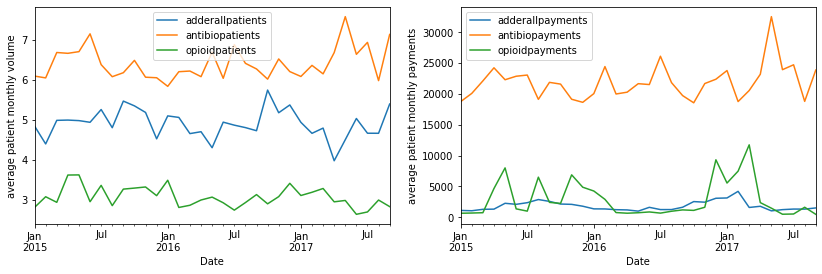

In [39]:
# Grouping the data by date and aggregating with mean. 
df1_d_avg = df1.loc[:'2017-09',:].groupby('Date').mean()

fig, axes = plt.subplots(1, 2, figsize=(14,4), squeeze=False)
df1_d_avg.loc[:,['adderallpatients','antibiopatients','opioidpatients']].plot(ax=axes[0, 0])
df1_d_avg.loc[:,['adderallpayments','antibiopayments','opioidpayments']].plot(ax=axes[0, 1])
axes[0,0].set_ylabel('average patient monthly volume')
axes[0,1].set_ylabel('average patient monthly payments') ;

The average monthly payments and average monthly patient volumes appear to be stationary over the period and the differences in means are consistent with earlier observations.

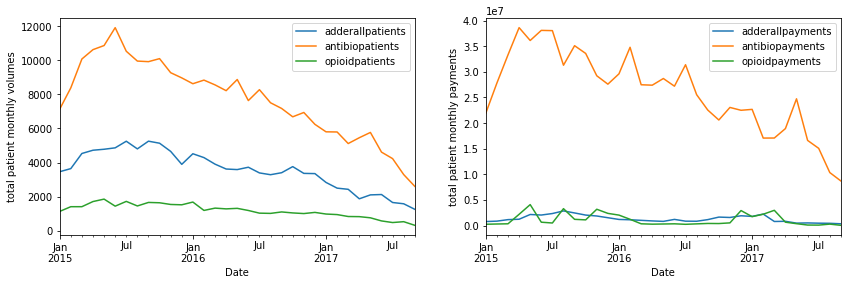

In [40]:
# Grouping the data by date and aggregating with sum. 
df1_d_sum = df1.loc[:'2017-09',:].groupby('Date').sum()

fig, axes = plt.subplots(1, 2, figsize=(14,4), squeeze=False)
df1_d_sum.loc[:,['adderallpatients','antibiopatients','opioidpatients']].plot(ax=axes[0, 0])
df1_d_sum.loc[:,['adderallpayments','antibiopayments','opioidpayments']].plot(ax=axes[0, 1])
axes[0,0].set_ylabel('total patient monthly volumes')
axes[0,1].set_ylabel('total patient monthly payments') ;

Surprisingly, unlike the average monthly aggregates, aggregating by sum shows a steady decline in total patient volumes for all drug types over the period. Additionally, while the total monthly payments for antibiotics also appeared to be steadily declining over the period, total monthly payments for adderall and opioids appeared stationary.

It is likely that the impact of outliers might have skewed the means resulting in the observation of stationary values for average patient volumes despite a steady decline in total patient volumes over the period.

### Subsetting the dataset for deeper time series analysis of patient volumes and payments
#### Time series prescription patterns of physicians that prescribed adderall and atleast one other drug type

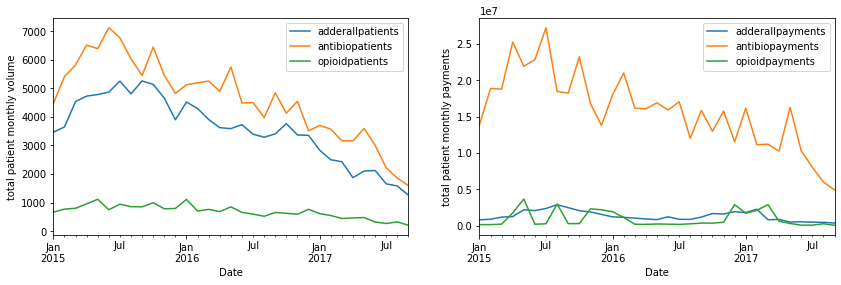

In [41]:
# Physicians that prescribed adderall and atleast one other drug type
adderall_phys_other = df1[df1['adderallpatients'].notnull()]

adderall_phys_other = adderall_phys_other.loc[:'2017-09',:].groupby('Date').sum()
fig, axes = plt.subplots(1, 2, figsize=(14,4), squeeze=False)
adderall_phys_other.loc[:,['adderallpatients','antibiopatients','opioidpatients']].plot(ax=axes[0, 0])
adderall_phys_other.loc[:,['adderallpayments','antibiopayments','opioidpayments']].plot(ax=axes[0, 1])
axes[0,0].set_ylabel('total patient monthly volume')
axes[0,1].set_ylabel('total patient monthly payments') ;

#### Time series prescription patterns of physicians that prescribed opioids and atleast one other drug type

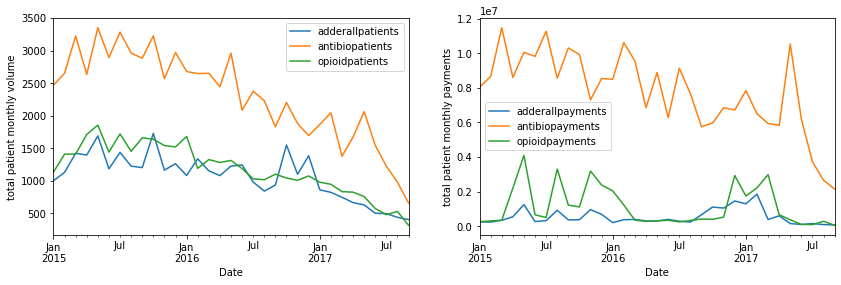

In [42]:
# Physicians that prescribed opioids and atleast one other drug type
opioid_phys_other = df1[df1['opioidpatients'].notnull()]

opioid_phys_other = opioid_phys_other.loc[:'2017-09',:].groupby('Date').sum()
fig, axes = plt.subplots(1, 2, figsize=(14,4), squeeze=False)
opioid_phys_other.loc[:,['adderallpatients','antibiopatients','opioidpatients']].plot(ax=axes[0, 0])
opioid_phys_other.loc[:,['adderallpayments','antibiopayments','opioidpayments']].plot(ax=axes[0, 1])
axes[0,0].set_ylabel('total patient monthly volume')
axes[0,1].set_ylabel('total patient monthly payments') ;

#### Time series prescription patterns of physicians likely overprescribing adderall

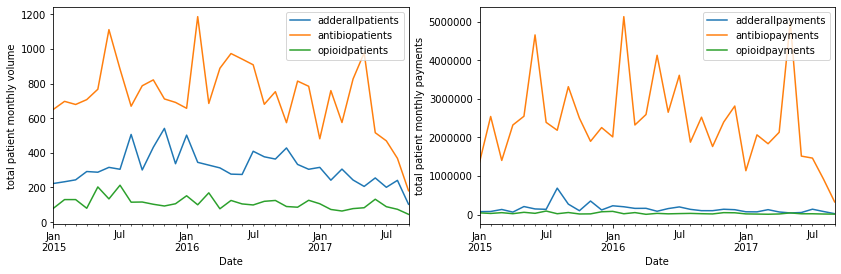

In [43]:
xs_phys_adderall = df1.loc[df1.physicianid.isin(xs_phys['adderall'])]

xs_phys_adderall = xs_phys_adderall.loc[:'2017-09',:].groupby('Date').sum()
fig, axes = plt.subplots(1, 2, figsize=(14,4), squeeze=False)
xs_phys_adderall.loc[:,['adderallpatients','antibiopatients','opioidpatients']].plot(ax=axes[0, 0])
xs_phys_adderall.loc[:,['adderallpayments','antibiopayments','opioidpayments']].plot(ax=axes[0, 1])
axes[0,0].set_ylabel('total patient monthly volume')
axes[0,1].set_ylabel('total patient monthly payments') ;

#### Time series prescription patterns of physicians likely overprescribing antibiotics

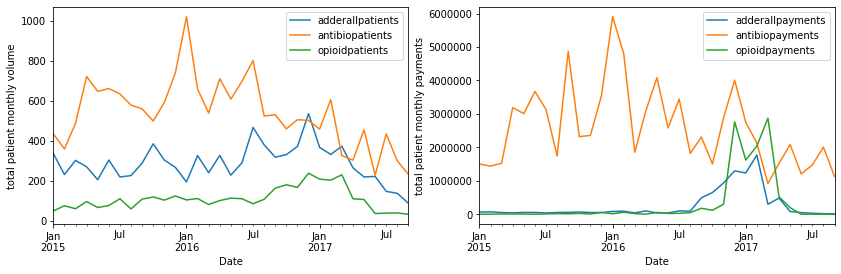

In [44]:
xs_phys_antibio = df1.loc[df1.physicianid.isin(xs_phys['antibio'])]

xs_phys_antibio = xs_phys_antibio.loc[:'2017-09',:].groupby('Date').sum()
fig, axes = plt.subplots(1, 2, figsize=(14,4), squeeze=False)
xs_phys_antibio.loc[:,['adderallpatients','antibiopatients','opioidpatients']].plot(ax=axes[0, 0])
xs_phys_antibio.loc[:,['adderallpayments','antibiopayments','opioidpayments']].plot(ax=axes[0, 1])
axes[0,0].set_ylabel('total patient monthly volume')
axes[0,1].set_ylabel('total patient monthly payments') ;

#### Time series prescription patterns of physicians likely overprescribing opioids

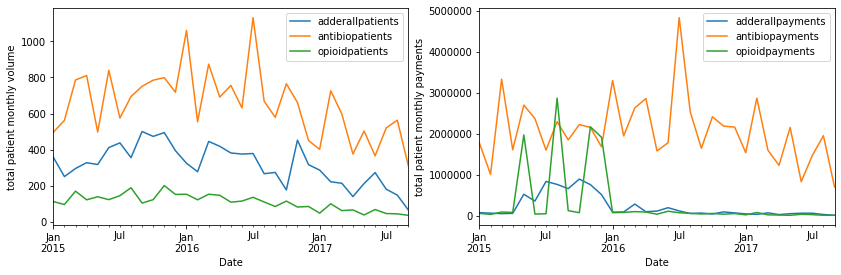

In [45]:
xs_phys_opioid = df1.loc[df1.physicianid.isin(xs_phys['opioid'])]

xs_phys_opioid = xs_phys_opioid.loc[:'2017-09',:].groupby('Date').sum()
fig, axes = plt.subplots(1, 2, figsize=(14,4), squeeze=False)
xs_phys_opioid.loc[:,['adderallpatients','antibiopatients','opioidpatients']].plot(ax=axes[0, 0])
xs_phys_opioid.loc[:,['adderallpayments','antibiopayments','opioidpayments']].plot(ax=axes[0, 1])
axes[0,0].set_ylabel('total patient monthly volume')
axes[0,1].set_ylabel('total patient monthly payments') ;

#### Time series prescription patterns of physicians likely overprescribing opioids and adderall

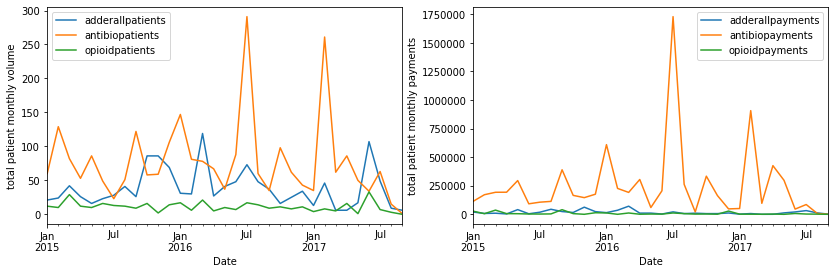

In [46]:
xs_phys_anti_opi = df1.loc[df1.physicianid.isin(xs_phys_add_opi)]

xs_phys_anti_opi = xs_phys_anti_opi.loc[:'2017-09',:].groupby('Date').sum()
fig, axes = plt.subplots(1, 2, figsize=(14,4), squeeze=False)
xs_phys_anti_opi.loc[:,['adderallpatients','antibiopatients','opioidpatients']].plot(ax=axes[0, 0])
xs_phys_anti_opi.loc[:,['adderallpayments','antibiopayments','opioidpayments']].plot(ax=axes[0, 1])
axes[0,0].set_ylabel('total patient monthly volume')
axes[0,1].set_ylabel('total patient monthly payments') ;